In [1]:
# Imports
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt

import datetime


#Settings
pd.set_option("display.max_rows", 70)
pd.set_option("display.max_columns", 101)

# Task Description

Case description:
Welcome to East Carmen Airlines! As a strategic data scientist, you are confronted with many use cases to digitalize the airline business. Most important for airlines are accurate predictions of flight arrivals during a day of operations. When it comes to passenger handling, such predictions would admit a proactive steering, in order that the passengers reach the connection flights and therefore save a lot of money.

Your model should be applicable to each aircraft in East Carmen’s fleet. Let us take as an example the aircraft with registration name EC-LPD. At scheduled departure of the earliest morning flight from East Carmen’s hub Madrid the model should predict all flights of EC-LPD on the given day.

Many business stakeholders do not trust in the robustness of such a model. They claim that for a given aircraft, one could predict the first flight of the day with a decent error, but the errors of second and third flights will be huge. It is now your task to convince the business stakeholders that with a well-prepared data set and meaningful features you can deliver robust flight predictions.

Project Aim:
From different departments business analysts have collected a lot of information on possible features for flight predictions. Now it is your task to use these data to deliver a prototype forecasting model for all flights of a given aircraft at scheduled departure of the first flight of the day. 

For instance, for an aircraft with registration name EC-LPD, first flight of the day (FFOD) scheduled at 5:30 am from MAD to VIE and with the connection chain MAD-VIE-MAD-CDG-MAD-LHR-MAD your model should predict the successive landing times in VIE, MAD, CDG, MAD, LHR, MAD. The colleagues from daily operations are especially interested in how the confidence level of such a model evolves during a day of operations.

# General Information
| Amendments by me


3.1 File Names
- zip-folder: use_case_3.zip
- flight_information.csv : information on flights in a given time period, where each data point is a so-called 
leg, i.e. a flight from departure airport to destination airport with all relevant flight and crew information
- ground_information.csv : information on the ground processes after landing at our hub “East Carmen”,
where each data point describes the processes between two flights (inbound = landing, outbound = takeoff).


3.2 Column Description – Flight Information
- leg_no: unique identifier of a flight on a given day, at a certain time, with a given flight number
- fn_carrier: airline name
- fn_number: flight number; has to be unique on a given day
- dep_ap_sched: scheduled departure airport
- arr_ap_sched: scheduled arrival airport
- dep_sched_date: scheduled departure date
- dep_sched_time: scheduled departure time
- arr_sched_date: scheduled arrival date
- arr_sched_time: scheduled arrival time
- m_offblockdt: timestamp of departure
- m_onblockdt: timestamp of arrival
- ac_registration: aircraft registration number, i.e. the “license plate” of the aircraft
- change_reason_code: reason for delay (assigned after the flight)
- dep_delay: departure delay
- Ac Type Code: aircraft type (example: 320 = Airbus A320)
- trans_time: true minimal transition time for crew members after flight, i.e. transition time of the crew
member with the least time
- sched_trans_time: scheduled minimal transition time for crew members after flight, i.e. scheduled transition
time of the crew member with the least time
4
- Crew Group: assignment of what happens to the whole crew after a flight
o Start : First flight of day
o A : all crew members stay on the aircraft for the next flight
o B, B2: all crew members switch aircraft for the next flight
o C: at least one crew member switches aircraft for the next flight
- TLC_trans: names of crew members on flight with some additional information attached to each name (but business does not know exactly which additional information is visible there)
- crew_type_change: rank (cp = pilot, ca = cabin member) of crew members, who changed aircraft
- Sched Groundtime: scheduled ground time of the aircraft between flights | has mistakes; mostly (dep_sched_time of next line) - (arr_sched_time of current line); groundtime AFTER landing
- Act Groundtime: actual ground time of the aircraft between flights | has mistakes; mostly (m_offblocktime of next line) - (m_onblocktime of current line); groundtime AFTER landing


3.3 Column Description – Ground Information
- Each datapoint consists of an inbound (=arriving) flight and an outbound (=departing) flight from our hub “East Carmen)
- Catering, cleaning and pax (=passenger) boarding durations given for our hub “East Carmen” between the inbound and outbound flights
- day_of_origin: day of flight (also given in Flight Information)
- ac_type: aircraft type (also given in Flight Information)
- fn_number: flight number (also given in Flight Information)
- ac_registration: aircraft registration (also given in Flight Information)
- mingt: minimal scheduled ground time for the given aircraft
- dep_leg_inbound: departure airport name of inbound (=arriving) flight
- arr_leg_inbound: arrival airport name of inbound (=arriving) flight
- arr_leg_outbound: departure airport name of outbound (=departing) flight
- sched_inbound_dep: scheduled departure time of inbound (=arriving) flight
- sched_inbound_arr: scheduled arrival time of inbound (=arriving) flight
- sched_outbound_dep: scheduled departure time of outbound (=departing) flight
- sched_outbound_arr: scheduled arrival time of outbound (=departing) flight
- sched_turnaround: scheduled ground time for aircraft
- leg_inbound: leg number of inbound flight
- leg_outbound: leg number of outbound flight
- catering_duration: catering duration (i.e. filling up meal boxes) between flights in minutes
- cleaning_duration: cleaning duration between flights in minutes
- pax_boarding_duration: boarding duration between flights in minutes


3.4 Additional Info from Business Side:
- BI (=business intelligence) colleagues have collected a lot of flight information from many different de-partments: flight-, crew- and ground operations. Each department uses a different data warehouse. BI colleagues claim that some of the columns might be redundant and some information could be wrong, due to bad and not consistent data in the different data warehouses of the business departments. It is central for this prototype study to clean and transform the data and make consistency checks, before applying a machine learning algorithm.

# Initial Dataset Structure

In [2]:
# some general functions

def na_count(dataframe):
    '''Takes a Pandas dataframe as input and returns NA-Values per attribute.'''
    for attribute in dataframe.columns:
        nan_abs = str(dataframe[attribute].isna().sum()) 
        nan_percent = str(round(dataframe[attribute].isna().sum() / dataframe.shape[0] *100, 2))

        print(str(attribute) + " NAs: " + nan_abs + "(" + nan_percent + "%)" )



In [3]:
# Read files 

flt_info = pd.read_csv('../data/raw/flight_information.csv', index_col = 0)
ground_info = pd.read_csv('../data/raw/ground_information.csv', index_col = 0)

# Variable type conversions

data_type_dict_flt_info = {
    'm_offblockdt' : 'datetime64',
    'm_onblockdt' : 'datetime64',
    'arr_sched_time' : 'str',
    'dep_sched_time' : 'str',
    'dep_sched_date' : 'datetime64',
    'arr_sched_date' : 'datetime64',
    
    
#    'fn_carrier' : 'category',
#    'fn_number' : 'category',
#    'dep_ap_sched' : 'category',
#    'arr_ap_sched' : 'category',
#    'ac_registration' : 'category',
#    'ac_registration' : 'category',


}

data_type_dict_ground_info = {
    'day_of_origin' : 'datetime64',
    'sched_inbound_dep' : 'datetime64',
    'sched_inbound_arr' : 'datetime64',
    'sched_outbound_dep' : 'datetime64',
    'sched_outbound_arr' : 'datetime64',
}

flt_info = flt_info.astype(data_type_dict_flt_info)
ground_info = ground_info.astype(data_type_dict_ground_info)

# Create correct datetimes for arr_sched_time and dep_sched_time
flt_info['dep_sched_time'] = pd.to_datetime(flt_info.dep_sched_date.astype(str) + ' ' + flt_info.dep_sched_time.astype(str))
flt_info['arr_sched_time'] = pd.to_datetime(flt_info.arr_sched_date.astype(str) + ' ' + flt_info.arr_sched_time.astype(str))


# Joining Datasets

full_df = pd.merge(flt_info, ground_info, left_on = ['fn_number', 'dep_sched_date'], right_on = ['fn_number','day_of_origin'], how = 'left')
full_df.head()

# We save the full unedited dataset

full_df_unedited = full_df
full_df_unedited.to_csv('../data/interim/full_df_unedited.csv')
full_df_unedited.to_pickle('../data/interim/full_df_unedited.pkl')

full_df.head()


,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,ac_type,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
0,272005011,East Carmen Airlines,EC3098,North Gregory,East Carmen,2019-06-01,2019-06-01 00:40:00,2019-06-01,2019-06-01 04:30:00,2019-06-01 00:43:00,2019-06-01 04:12:00,ECLBSX,other problem,3.0,320,0,0,Start,"['Jason Brown_nan_nan_nan_cp', 'Jacob Stein_na...",[],235.0,268.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
1,272009188,East Carmen Airlines,EC3146,Port Bobby,East Carmen,2019-06-01,2019-06-01 02:05:00,2019-06-01,2019-06-01 04:00:00,2019-06-01 01:58:00,2019-06-01 03:40:00,ECLWHX,no reason,-7.0,E95,0,0,Start,"['Scott Baker_nan_nan_nan_cp', 'Ruth Hoffman_n...",[],130.0,189.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
2,271984537,East Carmen Airlines,EC2840,Port Ryan,East Carmen,2019-06-01,2019-06-01 02:20:00,2019-06-01,2019-06-01 03:50:00,2019-06-01 02:24:00,2019-06-01 03:57:00,ECLGLX,other problem,4.0,DH4,0,0,Start,"['Cory Cooper_nan_nan_nan_ca', 'Morgan Foster_...",[],185.0,196.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
3,272025831,East Carmen Airlines,EC3306,Coleland,East Carmen,2019-06-01,2019-06-01 02:25:00,2019-06-01,2019-06-01 04:00:00,2019-06-01 02:28:00,2019-06-01 03:49:00,ECLBMX,other problem,3.0,320,0,0,Start,"['Anne Davis_nan_nan_nan_ca', 'Miss Amanda Har...",[],145.0,175.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN
4,272006092,East Carmen Airlines,EC3114,East Melissaberg,East Carmen,2019-06-01,2019-06-01 02:30:00,2019-06-01,2019-06-01 04:15:00,2019-06-01 03:02:00,2019-06-01 04:43:00,ECLGNX,other problem,32.0,DH4,0,0,Start,"['Renee Fisher_nan_nan_nan_ca', 'Rebecca Castr...",[],35.0,21.0,2019-06-01,DH4,ECLGNX,35.0,East Melissaberg,East Carmen,Keithberg,2019-06-01 02:30:00,2019-06-01 04:15:00,2019-06-01 04:50:00,2019-06-01 05:40:00,35.0,272006092.0,272205857.0,26.0,NaN,26.0


# Dataset Analysis

In [4]:
# Count of rows and columns of our data set
full_df.shape

(12185, 39)

### Rotation Analysis

This section aims at analysing for rotational mismatches, creating an indicator for it in the first place.

In [5]:
import functions

# Sorting data frame correctly
full_df = full_df.sort_values(by = ['ac_registration_x', 'm_offblockdt']).reset_index(drop = True)

# Create binary column indicating rotational mistakes
full_df = functions.create_rotmismatch(full_df)

# Create df with only dep_sched_date and ac_registration of rotational mistakes
rot_mistakes = full_df[full_df['rot_mismatch'] == True][['dep_sched_date','ac_registration_x']]

# Exclude full day of aircraft if there is one rotational mismatch
# As a rotational mismatch often causes further mistakes in the following lines, we exclude everything for the moment. By this, we lose 666 observations.
#flt_info_3_removed_rot_mistakes = flt_info.merge(rot_mistakes, how = 'outer', on = ['dep_sched_date','ac_registration'], indicator = True) # merge with table of rotational mistakes
#print(flt_info_3_removed_rot_mistakes['_merge'].value_counts())
#flt_info_3_removed_rot_mistakes = flt_info_3_removed_rot_mistakes[flt_info_3_removed_rot_mistakes['_merge'] == 'left_only'] # Filter out observations occuring in both

# save changed dataframe
#flt_info_3_removed_rot_mistakes.to_csv(
#    path_or_buf = 'C:/Users/PC Paul/Documents/Dokumente/DATA SCIENCE/Courses/Model_Engineering/Delay-Prediction/data/interim/flt_info_3_removed_rot_mistakes.csv')

#flt_info = flt_info_3_removed_rot_mistakes

#full_df.to_csv('C:/Users/PC Paul/Documents/Dokumente/DATA SCIENCE/Courses/Model_Engineering/DelayPrediction/data/interim/full_df_rotation_analysis.csv')

rot_mistakes

,dep_sched_date,ac_registration_x
374,2019-06-12,ECLBCX
550,2019-06-20,ECLBDX
678,2019-06-14,ECLBEX
855,2019-06-18,ECLBFX
955,2019-06-10,ECLBIX
...,...,...
11441,2019-06-27,ECLXAX
11442,2019-06-27,ECLXAX
11443,2019-06-27,ECLXAX
11444,2019-06-27,ECLXAX


In [50]:
full_df.head()

,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,ac_type,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,rot_mismatch
0,272024970,East Carmen Airlines,EC3292,New Jessica,East Carmen,2019-06-01,2019-06-01 03:25:00,2019-06-01,2019-06-01 06:45:00,2019-06-01 03:50:00,2019-06-01 07:01:00,ECLBAX,other problem,25.0,320,0,0,Start,"['Sean Weeks_nan_nan_nan_ca', 'Tony Lloyd_nan_...",[],95.0,94.0,2019-06-01,321,ECLBAX,45.0,New Jessica,East Carmen,South Nathaniel,2019-06-01 03:25:00,2019-06-01 06:45:00,2019-06-01 08:20:00,2019-06-01 10:35:00,95.0,272024970.0,272022230.0,27.0,NaN,25.0,False
1,272022230,East Carmen Airlines,EC3257,East Carmen,South Nathaniel,2019-06-01,2019-06-01 08:20:00,2019-06-01,2019-06-01 10:35:00,2019-06-01 08:35:00,2019-06-01 10:41:00,ECLBAX,other problem,15.0,320,60,60,B,"['Toni Rodriguez_48_60_60_ca', 'Rachel Smith_4...",[],75.0,120.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
2,272212848,East Carmen Airlines,EC3258,South Nathaniel,East Carmen,2019-06-01,2019-06-01 11:50:00,2019-06-01,2019-06-01 14:15:00,2019-06-01 12:41:00,2019-06-01 14:52:00,ECLBAX,rotational problem,51.0,320,68,75,A,"['Toni Rodriguez_127_68_75_ca', 'Rachel Smith_...",[],80.0,86.0,2019-06-01,321,ECLBAX,45.0,South Nathaniel,East Carmen,Joneshaven,2019-06-01 11:50:00,2019-06-01 14:15:00,2019-06-01 15:35:00,2019-06-01 17:00:00,80.0,272212848.0,271997824.0,25.0,NaN,NaN,False
3,271997824,East Carmen Airlines,EC3021,East Carmen,Joneshaven,2019-06-01,2019-06-01 15:35:00,2019-06-01,2019-06-01 17:00:00,2019-06-01 16:18:00,2019-06-01 17:32:00,ECLBAX,rotational problem,43.0,320,64,70,B2,"['Tyler Morris_224_64_70_ca', 'Sergio Cummings...","['ca', 'cp', 'ca', 'ca', 'ca']",50.0,32.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
4,271998033,East Carmen Airlines,EC3022,Joneshaven,East Carmen,2019-06-01,2019-06-01 17:50:00,2019-06-01,2019-06-01 19:10:00,2019-06-01 18:04:00,2019-06-01 19:14:00,ECLBAX,other problem,14.0,320,42,50,A,"['Sergio Cummings_279_42_50_cp', 'Jackie Black...",[],NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False


In [51]:
# Dataframe for analysis of rotational mistakes

rot_mistakes_analysis = full_df.merge(rot_mistakes, how = 'outer', on = ['dep_sched_date','ac_registration_x'], indicator = True) # merge with table of rotational mistakes
#print(rot_mistakes_analysis['_merge'].value_counts())
rot_mistakes_analysis = rot_mistakes_analysis[rot_mistakes_analysis['_merge'] == 'both'] # This creates the dataframe of all registrations and days having rotational mistakes. Let's see how we can fix them

rot_mistakes_analysis.head(10)

# We create a rolling window to analyse why lines get rotational mismatches
N = 1
mask = (full_df['rot_mismatch']
        .rolling(2*N+1, center=True, min_periods=1)
        .max().astype(bool)
       )
rotation_mismatch_lines = full_df.loc[mask]
rotation_mismatch_lines


,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,ac_type,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,rot_mismatch
373,271957792,East Carmen Airlines,EC2581,East Carmen,Lake Lawrencechester,2019-06-12,2019-06-12 15:10:00,2019-06-12,2019-06-12 16:40:00,2019-06-12 16:29:00,2019-06-12 17:51:00,ECLBCX,technical problem,79.0,320,59,85,B,"['Scott Torres_209_59_85_cp', 'Ryan Brown_209_...",[],70.0,9.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
374,271958002,East Carmen Airlines,EC2582,Lake Lawrencechester,East Carmen,2019-06-12,2019-06-12 17:50:00,2019-06-12,2019-06-12 19:15:00,2019-06-12 18:00:00,2019-06-12 19:19:00,ECLBCX,other problem,10.0,320,47,70,A,"['David Cruz_286_47_70_ca', 'Veronica Nunez_28...",[],NaN,NaN,2019-06-12,321,ECLBCX,45.0,Lake Lawrencechester,East Carmen,East Latashaview,2019-06-12 17:50:00,2019-06-12 19:15:00,2019-06-12 18:15:00,2019-06-12 21:40:00,-60.0,271958002.0,272213781.0,23.0,NaN,19.0,True
375,272027082,East Carmen Airlines,EC3316,East Latashaview,East Carmen,2019-06-13,2019-06-13 03:15:00,2019-06-13,2019-06-13 07:05:00,2019-06-13 03:34:00,2019-06-13 07:16:00,ECLBCX,other problem,19.0,320,0,0,Start,"['Reginald Grant_nan_nan_nan_cp', 'Jason Chane...",[],75.0,132.0,2019-06-13,321,ECLBCX,45.0,East Latashaview,East Carmen,South Nathaniel,2019-06-13 03:15:00,2019-06-13 07:05:00,2019-06-13 08:20:00,2019-06-13 10:35:00,75.0,272027082.0,272022242.0,15.0,NaN,33.0,False
549,272023984,East Carmen Airlines,EC3287,East Carmen,New Jessica,2019-06-20,2019-06-20 08:20:00,2019-06-20,2019-06-20 11:25:00,2019-06-20 08:38:00,2019-06-20 11:45:00,ECLBDX,other problem,18.0,320,68,60,B,"['Justin Medina_71_68_60_ca', 'Blake Rodriguez...",[],145.0,148.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False
550,272024194,East Carmen Airlines,EC3288,New Jessica,East Carmen,2019-06-20,2019-06-20 13:50:00,2019-06-20,2019-06-20 17:15:00,2019-06-20 14:13:00,2019-06-20 17:24:00,ECLBDX,other problem,23.0,320,0,0,Start,"['Angel Vazquez_nan_nan_nan_ca', 'Patrick Brow...",[],NaN,NaN,2019-06-20,322,ECLBDX,45.0,New Jessica,East Carmen,East Latashaview,2019-06-20 13:50:00,2019-06-20 17:15:00,2019-06-20 18:15:00,2019-06-20 21:40:00,60.0,272024194.0,272213789.0,25.0,NaN,20.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11442,272360102,East Carmen Airlines,EC3117,Lake Joelbury,East Carmen,2019-06-27,2019-06-27 11:30:00,2019-06-27,2019-06-27 12:30:00,2019-06-27 12:27:00,2019-06-27 13:29:00,ECLXAX,other problem,57.0,320,33,75,C,"['Meagan Russell_nan_nan_nan_ca', 'Stacy Johns...","['cp', 'cp']",-60.0,-326.0,2019-06-27,320,ECLXAX,40.0,Lake Joelbury,East Carmen,Youngland,2019-06-27 11:30:00,2019-06-27 12:30:00,2019-06-27 13:20:00,2019-06-27 14:55:00,50.0,272360102.0,272020340.0,28.0,NaN,51.0,True
11443,272360102,East Carmen Airlines,EC3117,Lake Joelbury,East Carmen,2019-06-27,2019-06-27 11:30:00,2019-06-27,2019-06-27 12:30:00,2019-06-27 12:27:00,2019-06-27 13:29:00,ECLXAX,other problem,57.0,320,23,105,A,"['Laura Meyer_100_23_105_ca', 'Shane Vang_100_...",[],50.0,32.0,2019-06-27,320,ECLXAX,40.0,Lake Joelbury,East Carmen,Youngland,2019-06-27 11:30:00,2019-06-27 12:30:00,2019-06-27 13:20:00,2019-06-27 14:55:00,50.0,272360102.0,272020340.0,28.0,NaN,51.0,True
11444,272360102,East Carmen Airlines,EC3117,Lake Joelbury,East Carmen,2019-06-27,2019-06-27 11:30:00,2019-06-27,2019-06-27 12:30:00,2019-06-27 12:27:00,2019-06-27 13:29:00,E

,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,mingt,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration
count,1.218500e+04,12185.000000,12185.000000,12185.000000,10172.000000,10098.000000,4341.000000,4341.000000,4.341000e+03,4.341000e+03,4341.000000,3.000000,3913.000000
mean,2.720521e+08,25.807961,27.904227,35.187115,61.527232,65.086156,39.131537,56.038931,2.720620e+08,2.720438e+08,21.966367,21.505556,18.478661
std,9.578455e+04,25.584889,31.823474,31.390048,59.056463,74.213465,3.215598,16.819141,9.955284e+04,9.316501e+04,4.323419,10.667400,11.889708
min,2.719556e+08,-14.000000,-134.000000,0.000000,-245.000000,-383.000000,30.000000,-120.000000,2.719558e+08,2.719560e+08,15.000000,14.000000,0.000000
25%,2.719829e+08,9.000000,0.000000,0.000000,45.000000,33.000000,40.000000,45.000000,2.719901e+08,2.719841e+08,18.000000,15.400000,13.000000
50%,2.720119e+08,17.000000,28.000000,45.000000,50.000000,59.000000,40.000000,55.000000,2.720164e+08,2.720105e+08,22.000000,16.800000,17.000000
75%,2.721017e+08,35.000000,49.000000,50.000000,65.000000,87.000000,40.000000,65.000000,2.721827e+08,2.720343e+08,26.000000,25.258333,22.000000
max,2.723603e+08,476.000000,470.000000,495.000000,945.000000,947.000000,45.000000,100.000000,2.723601e+08,2.723580e+08,29.000000,33.716667,491.000000


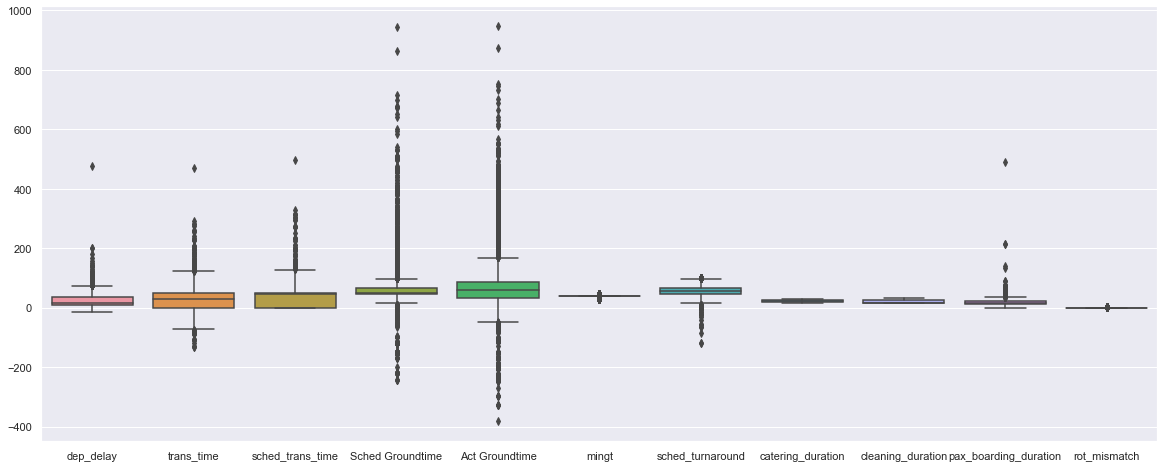

In [52]:
# Visualizing outliers

sns.set(rc={'figure.figsize':(20, 8)})
sns.boxplot(data = full_df.drop(['leg_no','leg_inbound', 'leg_outbound'], axis = 1))
full_df.describe()

This raises several questions for later analysis:
- Why do we have negative values for timedeltas? (Sched Groundtime, Act Groundtime, trans_time, sched_turnaround)
- Especially for sched_turnaround: Can this be correct? Misplanning of flights? 

### Duplicate Removal

Let's first check whether those are duplicates and whether removing them helps us. 

In [53]:
# We create an indicator whether we want to drop the corresponding row.
# This persists the order of the dataframe in case we need it later on

# We use the subset of leg_no as this is the closest we can get to a data-inherent identifier. If there are dupes in this subset, it is highly likely that the whole row is not reliable.
full_df["rows_to_drop"] = np.where(full_df.duplicated(subset = ['leg_no'], keep = False) == True, 1,0)
full_df['rows_to_drop'].value_counts()

0    11937
1      248
Name: rows_to_drop, dtype: int64

In [54]:
# Should we keep some observations of the dupes or none at all?

full_df[full_df['rows_to_drop'] == 1].head()

# Scoping thourgh this data frame for a bit reveals that some observations are more likely than others, but often we cannot clearly identify the correct observation. 
# Consequently, we drop all duplicates and keep none of them. 

,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,ac_type,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,rot_mismatch,rows_to_drop
1222,272218014,East Carmen Airlines,EC11525,East Allisontown,Aaronbury,2019-06-29,2019-06-29 16:25:00,2019-06-29,2019-06-29 17:05:00,2019-06-29 16:27:00,2019-06-29 17:07:00,ECLBJX,other problem,2.0,320,33,45,A,"['Erika Sandoval_232_33_45_cp', 'Julia Hollowa...",[],-40.0,64.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,True,1
1223,272218014,East Carmen Airlines,EC11525,East Allisontown,Aaronbury,2019-06-29,2019-06-29 16:25:00,2019-06-29,2019-06-29 17:05:00,2019-06-29 16:28:00,2019-06-29 17:08:00,ECLBJX,other problem,3.0,320,0,0,Start,"['Robert Williams_nan_nan_nan_ca', 'Holly Cook...",[],50.0,50.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,1
1224,272101016,East Carmen Airlines,EC11525,Aaronbury,North Stephenville,2019-06-29,2019-06-29 17:55:00,2019-06-29,2019-06-29 20:30:00,2019-06-29 17:58:00,2019-06-29 20:20:00,ECLBJX,other problem,3.0,320,0,0,Start,"['Robert Williams_nan_nan_nan_ca', 'Holly Cook...",[],50.0,80.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,True,1
1225,272101016,East Carmen Airlines,EC11525,Aaronbury,North Stephenville,2019-06-29,2019-06-29 17:55:00,2019-06-29,2019-06-29 20:30:00,2019-06-29 18:11:00,2019-06-29 20:33:00,ECLBJX,rotational problem,16.0,320,33,45,A,"['Erika Sandoval_232_33_45_cp', 'Julia Hollowa...",[],-155.0,-245.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,1
1387,272088110,East Carmen Airlines,EC11860,New Stacyburgh,East Michael,2019-06-27,2019-06-27 08:50:00,2019-06-27,2019-06-27 09:45:00,2019-06-27 08:53:00,2019-06-27 09:59:00,ECLBKX,other problem,3.0,320,-49,45,A,"['Mary Jones_88_-49_45_ca', 'Justin Roth_88_-4...",[],-55.0,34.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,True,1


,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,mingt,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,rows_to_drop
count,1.218500e+04,12185.000000,12185.000000,12185.000000,10172.000000,10098.000000,4341.000000,4341.000000,4.341000e+03,4.341000e+03,4341.000000,3.000000,3913.000000,12185.000000
mean,2.720521e+08,25.807961,27.904227,35.187115,61.527232,65.086156,39.131537,56.038931,2.720620e+08,2.720438e+08,21.966367,21.505556,18.478661,0.020353
std,9.578455e+04,25.584889,31.823474,31.390048,59.056463,74.213465,3.215598,16.819141,9.955284e+04,9.316501e+04,4.323419,10.667400,11.889708,0.141210
min,2.719556e+08,-14.000000,-134.000000,0.000000,-245.000000,-383.000000,30.000000,-120.000000,2.719558e+08,2.719560e+08,15.000000,14.000000,0.000000,0.000000
25%,2.719829e+08,9.000000,0.000000,0.000000,45.000000,33.000000,40.000000,45.000000,2.719901e+08,2.719841e+08,18.000000,15.400000,13.000000,0.000000
50%,2.720119e+08,17.000000,28.000000,45.000000,50.000000,59.000000,40.000000,55.000000,2.720164e+08,2.720105e+08,22.000000,16.800000,17.000000,0.000000
75%,2.721017e+08,35.000000,49.000000,50.000000,65.000000,87.000000,40.000000,65.000000,2.721827e+08,2.720343e+08,26.000000,25.258333,22.000000,0.000000
max,2.723603e+08,476.000000,470.000000,495.000000,945.000000,947.000000,45.000000,100.000000,2.723601e+08,2.723580e+08,29.000000,33.716667,491.000000,1.000000


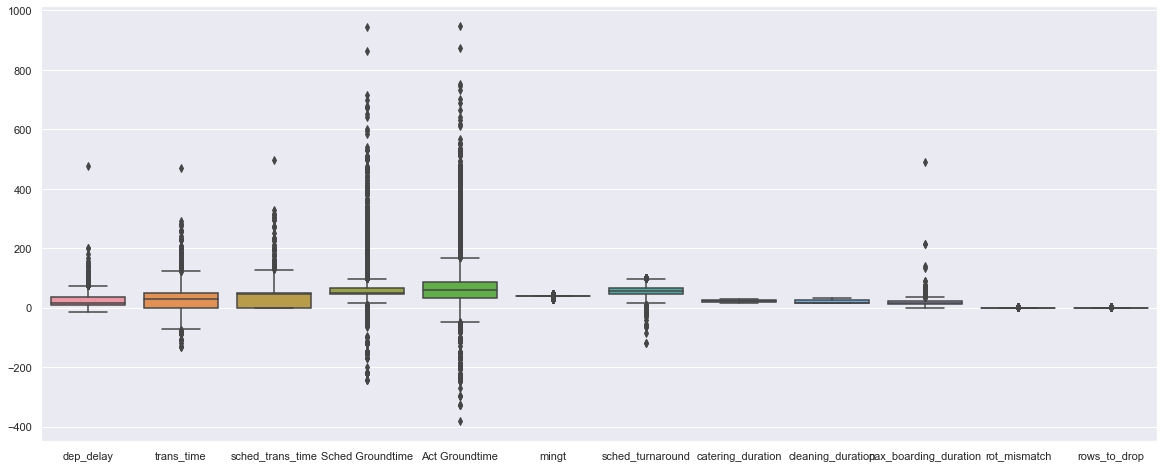

In [55]:
# Visualizing outliers again 

sns.set(rc={'figure.figsize':(20, 8)})
sns.boxplot(data = full_df.drop(['leg_no','leg_inbound', 'leg_outbound'], axis = 1))
full_df.describe()

We see that still many unexplainable negative values remain. We care about that later and first have a more intensive look on our NaNs.

Unique values per categorical feature

<AxesSubplot:title={'center':'Unique values per feature'}>

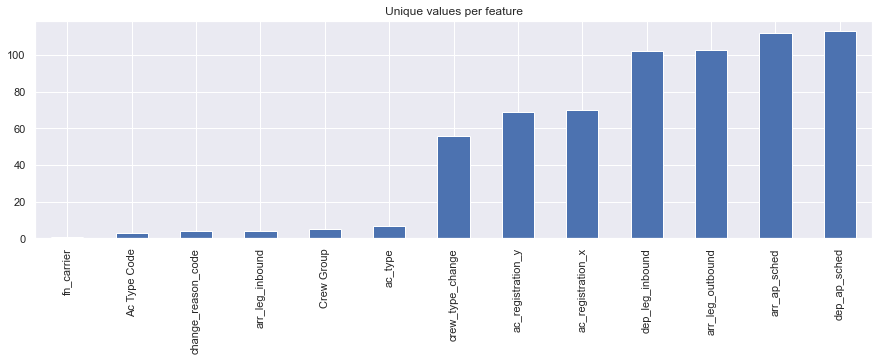

In [56]:
# Get unique values
unique_values = full_df.select_dtypes(include = 'object').nunique().sort_values().drop(['TLC_trans', 'fn_number'])

# Plot
unique_values.plot.bar(figsize = (15,4), title = "Unique values per feature")

## NaN Analysis

Overall check of NaN Values

In [57]:
# Count the number of NAs per variable
na_count(full_df)

leg_no NAs: 0(0.0%)
fn_carrier NAs: 0(0.0%)
fn_number NAs: 0(0.0%)
dep_ap_sched NAs: 0(0.0%)
arr_ap_sched NAs: 0(0.0%)
dep_sched_date NAs: 0(0.0%)
dep_sched_time NAs: 0(0.0%)
arr_sched_date NAs: 0(0.0%)
arr_sched_time NAs: 0(0.0%)
m_offblockdt NAs: 0(0.0%)
m_onblockdt NAs: 95(0.78%)
ac_registration_x NAs: 0(0.0%)
change_reason_code NAs: 0(0.0%)
dep_delay NAs: 0(0.0%)
Ac Type Code NAs: 0(0.0%)
trans_time NAs: 0(0.0%)
sched_trans_time NAs: 0(0.0%)
Crew Group NAs: 0(0.0%)
TLC_trans NAs: 0(0.0%)
crew_type_change NAs: 0(0.0%)
Sched Groundtime NAs: 2013(16.52%)
Act Groundtime NAs: 2087(17.13%)
day_of_origin NAs: 7844(64.37%)
ac_type NAs: 7844(64.37%)
ac_registration_y NAs: 7844(64.37%)
mingt NAs: 7844(64.37%)
dep_leg_inbound NAs: 7844(64.37%)
arr_leg_inbound NAs: 7844(64.37%)
arr_leg_outbound NAs: 7849(64.42%)
sched_inbound_dep NAs: 7844(64.37%)
sched_inbound_arr NAs: 7844(64.37%)
sched_outbound_dep NAs: 7844(64.37%)
sched_outbound_arr NAs: 7844(64.37%)
sched_turnaround NAs: 7844(64.37%)
leg

<AxesSubplot:>

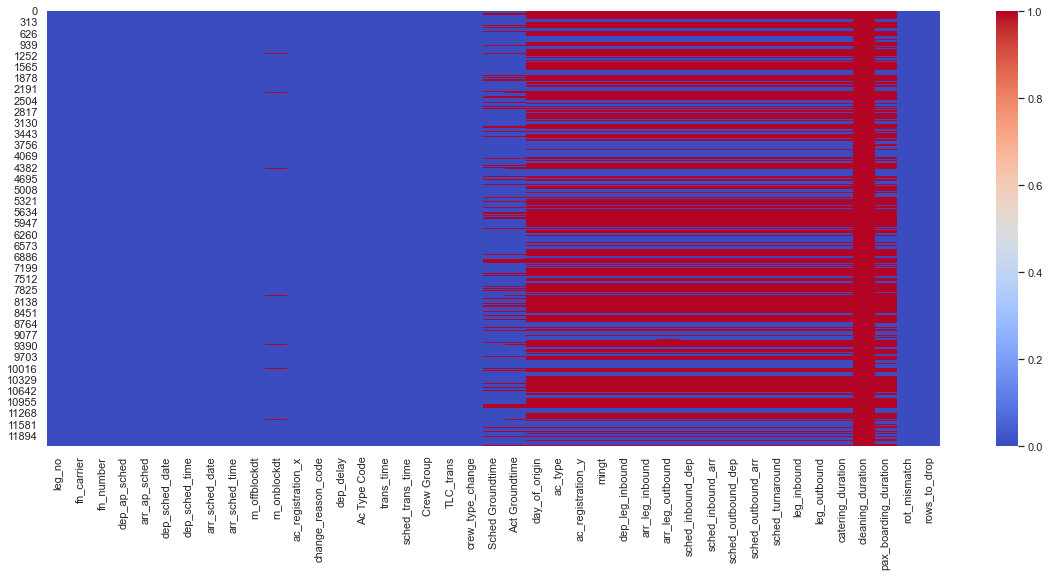

In [58]:
# visually

sns.heatmap(full_df.isnull(), cmap='coolwarm')

Notes
We make the following notes:
- feature cleaning_duration can be dropped as it provides no additional knowledge (actually, it only has three observations)
- most NAs occur due to the ground data not having a match within the left join. This is expected as we only have ground data for East Carmen. 
- we still have a few NAs for m_onblockdt, Sched Groundtime and Act Groundtime. Those should be investigated. 

### Feature m_onblockdate

In [59]:
m_onblockdt_NA = full_df[(full_df['m_onblockdt'].isna() == True) & (full_df['rows_to_drop'] == 0 )]
m_onblockdt_NA



,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,ac_type,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,rot_mismatch,rows_to_drop
15,272213772,East Carmen Airlines,EC3315,East Carmen,East Latashaview,2019-06-03,2019-06-03 18:15:00,2019-06-03,2019-06-03 21:40:00,2019-06-03 18:27:00,NaT,ECLBAX,other problem,12.0,320,0,0,Start,"['James Bailey_nan_nan_nan_ca', 'Brian Gomez_n...",[],NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,0
37,272023973,East Carmen Airlines,EC3287,East Carmen,New Jessica,2019-06-09,2019-06-09 08:20:00,2019-06-09,2019-06-09 11:25:00,2019-06-09 08:40:00,NaT,ECLBAX,other problem,20.0,320,91,85,B2,"['Lindsey Martinez_32_91_85_ca', 'Kristy Harpe...","['ca', 'cp', 'cp', 'ca', 'ca']",145.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,0
216,271962549,East Carmen Airlines,EC2627,East Carmen,Susanmouth,2019-06-12,2019-06-12 15:30:00,2019-06-12,2019-06-12 17:05:00,2019-06-12 16:53:00,NaT,ECLBBX,technical problem,83.0,320,50,60,C,"['Amy Reyes_243_50_60_cp', 'Lindsey Saunders_2...","['cp', 'ca', 'ca', 'cp']",45.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,0
567,272025160,East Carmen Airlines,EC3300,Coleland,East Carmen,2019-06-24,2019-06-24 02:25:00,2019-06-24,2019-06-24 04:00:00,2019-06-24 02:26:00,NaT,ECLBDX,other problem,1.0,320,0,0,Start,"['Barbara Stout_nan_nan_nan_ca', 'Stacey Green...",[],65.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,0
667,271968173,East Carmen Airlines,EC2680,West Jason,East Carmen,2019-06-12,2019-06-12 07:00:00,2019-06-12,2019-06-12 08:20:00,2019-06-12 07:02:00,NaT,ECLBEX,other problem,2.0,320,32,45,A,"['Grant Gonzalez_42_32_45_ca', 'Ariel Hall_42_...",[],0.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11415,271977647,East Carmen Airlines,EC2761,East Carmen,North Jeffrey,2019-06-24,2019-06-24 15:35:00,2019-06-24,2019-06-24 17:20:00,2019-06-24 16:02:00,NaT,ECLXAX,rotational problem,27.0,320,34,55,A,"['Lindsey Hodges_251_34_55_ca', 'Bonnie Harrel...",[],45.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,0
11777,271987568,East Carmen Airlines,EC2882,Navarroville,East Carmen,2019-06-21,2019-06-21 13:05:00,2019-06-21,2019-06-21 14:45:00,2019-06-21 13:05:00,NaT,ECLXCX,no reason,0.0,320,21,40,A,"['Christina Valdez_156_21_40_ca', 'Lynn Murphy...",[],200.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,0
11875,272184352,East Carmen Airlines,EC2630,Susanmouth,East Carmen,2019-06-08,2019-06-08 13:05:00,2019-06-08,2019-06-08 14:40:00,2019-06-08 13:05:00,NaT,ECLXDX,no reason,0.0,320,42,45,A,"['Kenneth Morrow_nan_nan_nan_ca', 'Teresa Bair...",['ca'],60.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,0
11892,271957520,East Carmen Airlines,EC2579,East Carmen,Lake Lawrencechester,2019-06-11,2019-06-11 10:10:00,2019-06-11,2019-06-11 11:40:00,2019-06-11 10:34:00,NaT,ECLXDX,other problem,24.0,320,114,105,B2,"['Daniel Young_90_114_105_ca', 'Mathew Andrade...","['ca', 'cp', 'cp', 'ca', 'ca']",70.0,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,0


<AxesSubplot:>

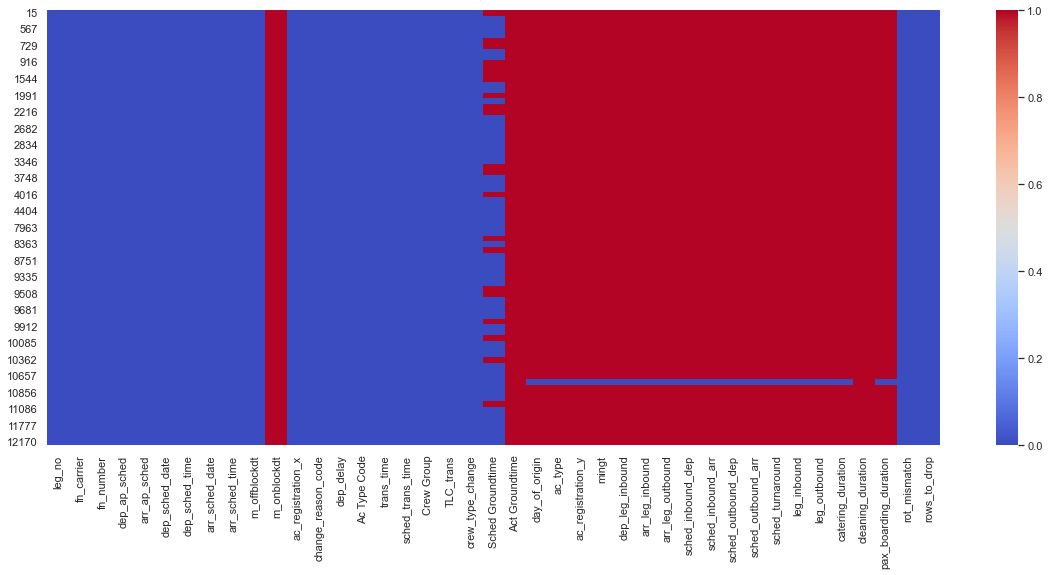

In [60]:
sns.heatmap(m_onblockdt_NA.isnull(), cmap='coolwarm')

Notes
- Whenever m_onblockdt is NaT, Act Groundtime is also NA. 
- This might indicate that there was a flight irregularity and the flight did not depart and consequently had no onblock at the arrival. 
- However, at a certain point, flight delay can also be such huge irregularity that a flight is cancelled although this happens seldomly. 
Regardless the reason, we are talking about 79 observations, having some 12'000 observations, so further in depth analysis might be interesting at a later stage, but not now. 
We consequently drop those rows as well.



In [44]:
# Mark m_onblockdt NAs for dropping

print(full_df['rows_to_drop'].sum())
full_df["rows_to_drop"] = np.where(full_df['m_onblockdt'].isna() == True, full_df["rows_to_drop"] + 1, full_df["rows_to_drop"])
print(full_df['rows_to_drop'].sum())


343
438


TH1: If Sched Groundtime is NA, Act Groundtime is also NA --> True. Act Groundtime also has more NAs than Sched Groundtime. See H3


<AxesSubplot:>

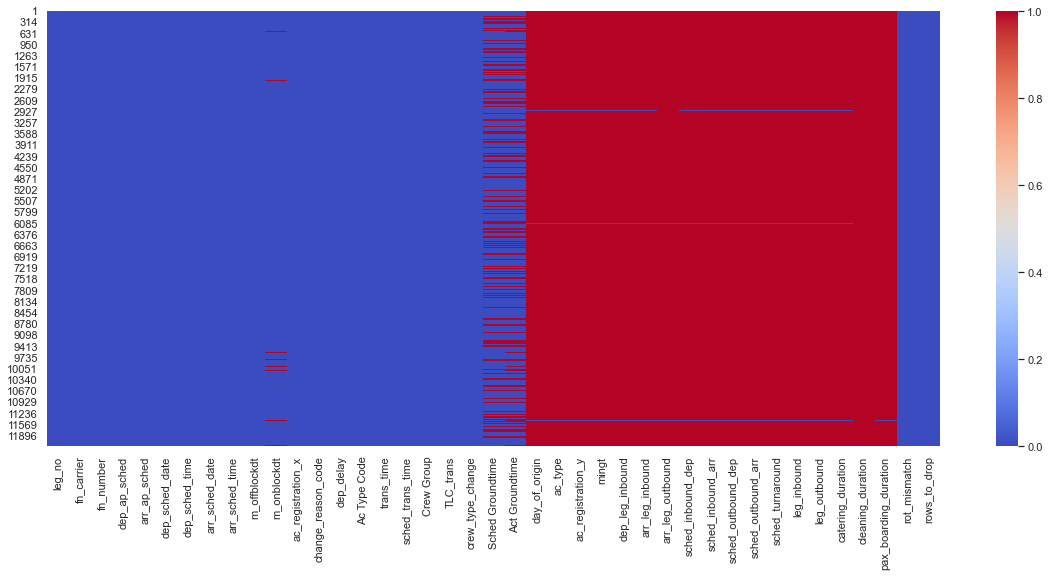

In [17]:
#Hypothesis 1:
full_df_NA = full_df[full_df.drop(['cleaning_duration', 'pax_boarding_duration'], axis = 1).isna().any(axis = 1)]
sns.heatmap(full_df_NA.isnull(), cmap='coolwarm')

In [18]:
full_df_NA.describe()
# Whenever there is a line with a NA value, Act Groundtime has NA. 

,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,mingt,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,rows_to_drop
count,7.897000e+03,7897.000000,7897.000000,7897.000000,5884.000000,5810.000000,53.000000,53.000000,5.300000e+01,5.300000e+01,53.000000,0.0,47.000000,7897.000000
mean,2.720474e+08,26.040142,27.741168,34.604913,67.912984,63.834251,39.811321,56.603774,2.720953e+08,2.720457e+08,23.490566,NaN,22.617021,0.005065
std,9.402459e+04,23.741378,33.621261,33.238944,69.758174,84.214301,1.951889,27.800346,1.244262e+05,1.145516e+05,4.370454,NaN,13.846288,0.070994
min,2.719556e+08,-14.000000,-134.000000,0.000000,-245.000000,-270.000000,30.000000,-65.000000,2.719580e+08,2.719571e+08,15.000000,NaN,7.000000,0.000000
25%,2.719796e+08,12.000000,0.000000,0.000000,45.000000,22.250000,40.000000,50.000000,2.720284e+08,2.719768e+08,21.000000,NaN,15.000000,0.000000
50%,2.720086e+08,19.000000,25.000000,40.000000,45.000000,48.000000,40.000000,60.000000,2.720284e+08,2.720126e+08,24.000000,NaN,17.000000,0.000000
75%,2.721009e+08,34.000000,51.000000,55.000000,65.000000,78.000000,40.000000,65.000000,2.720885e+08,2.720203e+08,28.000000,NaN,21.000000,0.000000
max,2.723603e+08,149.000000,470.000000,495.000000,945.000000,947.000000,45.000000,100.000000,2.723601e+08,2.723527e+08,29.000000,NaN,51.000000,1.000000


H2: Last flight of the day has no value for Sched Groundtime and Act Groundtime

In [19]:
#analysis for single registration and dep day
full_df[(full_df['ac_registration_x'] == 'ECLWHX') & (full_df['dep_sched_date'] == "2019-06-14")]

# We see that the last flight of a given day has no Sched Groundtime and no Act Groundtime, at least in this example. However, it repeats for different combinations,
# so we assume it's universally true. 

,leg_no,fn_carrier,fn_number,dep_ap_sched,arr_ap_sched,dep_sched_date,dep_sched_time,arr_sched_date,arr_sched_time,m_offblockdt,m_onblockdt,ac_registration_x,change_reason_code,dep_delay,Ac Type Code,trans_time,sched_trans_time,Crew Group,TLC_trans,crew_type_change,Sched Groundtime,Act Groundtime,day_of_origin,ac_type,ac_registration_y,mingt,dep_leg_inbound,arr_leg_inbound,arr_leg_outbound,sched_inbound_dep,sched_inbound_arr,sched_outbound_dep,sched_outbound_arr,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,rot_mismatch,rows_to_drop
9400,271994247,East Carmen Airlines,EC2984,East Holly,East Carmen,2019-06-14,2019-06-14 05:25:00,2019-06-14,2019-06-14 06:30:00,2019-06-14 05:25:00,2019-06-14 06:33:00,ECLWHX,no reason,0.0,E95,0,0,Start,"['Robert Holland_nan_nan_nan_ca', 'Brian Steve...",[],80.0,97.0,2019-06-14,E95,ECLWHX,40.0,East Holly,East Carmen,Lake David,2019-06-14 05:25:00,2019-06-14 06:30:00,2019-06-14 07:50:00,2019-06-14 09:40:00,80.0,271994247.0,272002947.0,22.0,NaN,23.0,False,0
9401,272002947,East Carmen Airlines,EC3075,East Carmen,Lake David,2019-06-14,2019-06-14 07:50:00,2019-06-14,2019-06-14 09:40:00,2019-06-14 08:10:00,2019-06-14 10:12:00,ECLWHX,other problem,20.0,E95,30,40,B,"['Janet Walls_31_30_40_cp', 'Melissa Walker_31...",[],55.0,35.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,0
9402,272003149,East Carmen Airlines,EC3076,Lake David,East Carmen,2019-06-14,2019-06-14 10:35:00,2019-06-14,2019-06-14 12:30:00,2019-06-14 10:47:00,2019-06-14 12:41:00,ECLWHX,other problem,12.0,E95,26,55,A,"['Janet Walls_105_26_55_cp', 'Melissa Walker_1...",[],50.0,66.0,2019-06-14,E95,ECLWHX,40.0,Lake David,East Carmen,West Danielport,2019-06-14 10:35:00,2019-06-14 12:30:00,2019-06-14 13:20:00,2019-06-14 14:50:00,50.0,272003149.0,271991661.0,25.0,NaN,8.0,False,0
9403,271991661,East Carmen Airlines,EC2969,East Carmen,West Danielport,2019-06-14,2019-06-14 13:20:00,2019-06-14,2019-06-14 14:50:00,2019-06-14 13:47:00,2019-06-14 15:05:00,ECLWHX,rotational problem,27.0,E95,0,0,Start,"['Daniel Olson_nan_nan_nan_cp', 'Courtney Camp...",[],50.0,44.0,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,0
9404,271991812,East Carmen Airlines,EC2970,West Danielport,East Carmen,2019-06-14,2019-06-14 15:40:00,2019-06-14,2019-06-14 17:10:00,2019-06-14 15:49:00,2019-06-14 17:08:00,ECLWHX,other problem,9.0,E95,40,50,A,"['Logan Beck_257_40_50_ca', 'Daniel Anderson_2...",[],65.0,80.0,2019-06-14,E95,ECLWHX,40.0,West Danielport,East Carmen,Davidtown,2019-06-14 15:40:00,2019-06-14 17:10:00,2019-06-14 18:15:00,2019-06-14 20:10:00,65.0,271991812.0,271983669.0,20.0,NaN,23.0,False,0
9405,271983669,East Carmen Airlines,EC2833,East Carmen,Davidtown,2019-06-14,2019-06-14 18:15:00,2019-06-14,2019-06-14 20:10:00,2019-06-14 18:28:00,2019-06-14 20:10:00,ECLWHX,other problem,13.0,E95,0,0,Start,"['Henry Rose_nan_nan_nan_cp', 'Melanie Fuentes...",[],NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,False,0


Hypothesis 3: m_onblockdt NAs have values for Sched Groundtime but not for Act Groundtime (to be verified). Those could be cancelled/diverted etc. flts

<AxesSubplot:>

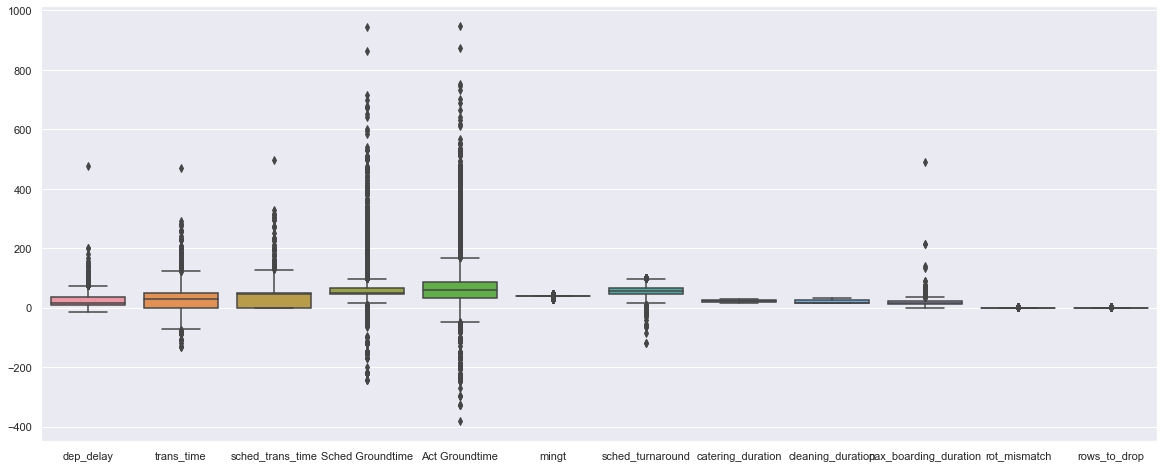

In [20]:
sns.set(rc={'figure.figsize':(20, 8)})
sns.boxplot(data = full_df.drop(['leg_no', 'leg_inbound', 'leg_outbound'], axis = 1))

# Todo: Check negative ground time 



## Negative Ground Time Check

H: If arr_ap_sched == East Carmen and there is no match for that observation in ground data, the Groundtime figures are wrong

(11058, 3)


C:\Users\PC Paul\AppData\Local\Temp\ipykernel_7620\1204411467.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  full_df_temp['no_merge_match'] = pd.isna(full_df_temp['dep_leg_inbound'])   # Create indicator for match in ground data


<AxesSubplot:xlabel='variable', ylabel='value'>

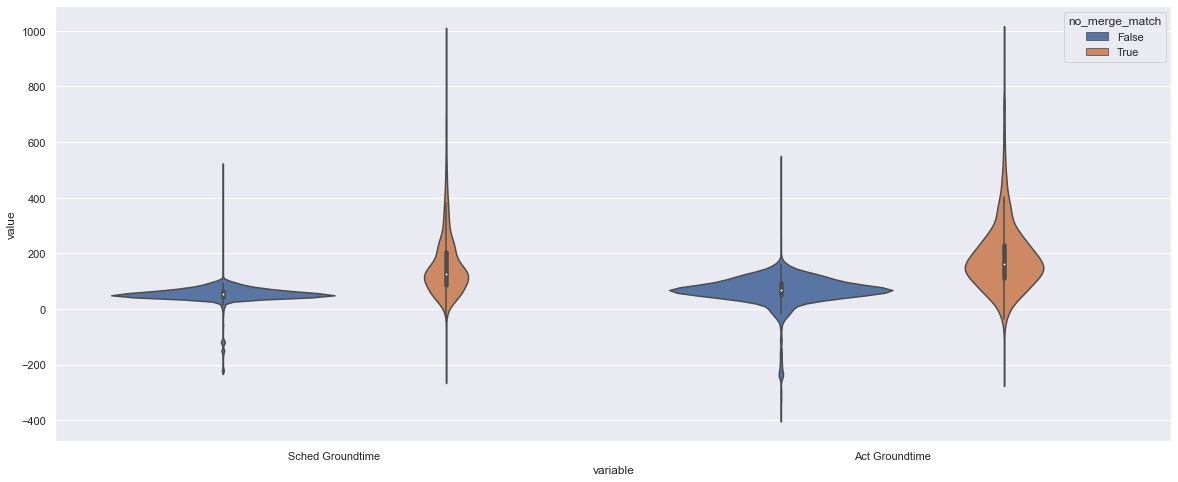

In [21]:
# One observation looking at the raw data above suggested suspiciously high ground times if arrival airport is East Carmen while there is no match in ground data. Let's check that. 

sns.set(rc={'figure.figsize':(20, 8)})
full_df_temp = full_df[full_df['arr_ap_sched'] == 'East Carmen']
#full_df_temp = full_df_temp[full_df_temp['rows_to_drop'] == 0]

full_df_temp['no_merge_match'] = pd.isna(full_df_temp['dep_leg_inbound'])   # Create indicator for match in ground data
full_df_temp_describe = full_df_temp    # for the desribe function in the next field

full_df_temp = pd.melt(full_df_temp, value_vars = ['Sched Groundtime', 'Act Groundtime'], id_vars = 'no_merge_match')
print(full_df_temp.shape)
sns.violinplot(x='variable', y='value', hue = 'no_merge_match', data = full_df_temp) 

In [22]:
full_df_temp_describe.describe()

,leg_no,dep_delay,trans_time,sched_trans_time,Sched Groundtime,Act Groundtime,mingt,sched_turnaround,leg_inbound,leg_outbound,catering_duration,cleaning_duration,pax_boarding_duration,rows_to_drop
count,5.529000e+03,5529.000000,5529.000000,5529.000000,4838.000000,4815.000000,4226.000000,4226.000000,4.226000e+03,4.226000e+03,4226.000000,0.0,3817.000000,5529.000000
mean,2.720584e+08,21.363357,26.824200,36.633207,66.898512,81.797715,39.115002,56.178419,2.720601e+08,2.720432e+08,21.959773,NaN,18.467645,0.020619
std,9.814210e+04,27.266808,28.683919,26.685247,65.710029,80.338690,3.248672,16.438384,9.904162e+04,9.311320e+04,4.325216,NaN,11.913937,0.142116
min,2.719558e+08,-14.000000,-134.000000,0.000000,-220.000000,-383.000000,30.000000,-85.000000,2.719558e+08,2.719560e+08,15.000000,NaN,0.000000,0.000000
25%,2.719876e+08,2.000000,0.000000,0.000000,45.000000,52.000000,40.000000,45.000000,2.719897e+08,2.719841e+08,18.000000,NaN,13.000000,0.000000
50%,2.720148e+08,12.000000,30.000000,45.000000,55.000000,74.000000,40.000000,55.000000,2.720156e+08,2.720094e+08,22.000000,NaN,17.000000,0.000000
75%,2.721712e+08,27.000000,46.000000,45.000000,70.000000,106.000000,40.000000,65.000000,2.721834e+08,2.720343e+08,26.000000,NaN,22.000000,0.000000
max,2.723601e+08,476.000000,260.000000,270.000000,945.000000,947.000000,45.000000,100.000000,2.723601e+08,2.723580e+08,29.000000,NaN,491.000000,1.000000


In [23]:
# Something definitely seems off with the East Carmen arrival lines that do not have any match for ground data.. 

In [24]:
# 22APR: This cell is partially irrelevant as we remove dupes already at the beginning

# Excel analysis shows that many negative scheduled groundtimes are duplicate leg_no.
# Duplicate removal 
#flt_info_2_removed_dupes_leg_no = flt_info.drop_duplicates(subset = ['leg_no'], keep = False) #for the moment, we remove the duplicates completely as they are not many and we cannot say which one is correct.

#flt_info = flt_info_2_removed_dupes_leg_no

# 22APR: Note: if you reactivate these lines, save the removed rows, not the df
# save changed dataframe
#flt_info_2_removed_dupes_leg_no.to_csv(
#    path_or_buf = '../data/interim/flt_info_2_removed_dupes_leg_no.csv')

# And we see, the negative values reduce. 
#sns.set(rc={'figure.figsize':(12, 8)})
#sns.boxplot(data = flt_info.drop(['leg_no'], axis = 1))

#flt_info.describe()

# looking at the remaining values, we see some rotational mismatches


TH5: Groundtime reliability differs per A/C Registration

In [25]:
flt_info['Neg_Sched_Groundtime'] = np.where(flt_info['Sched Groundtime']<0,'Yes','No')
flt_info['Neg_Act_Groundtime'] = np.where(flt_info['Act Groundtime']<0,'Yes','No')
print(flt_info['Neg_Sched_Groundtime'].value_counts(), "\n")
print(flt_info['Neg_Act_Groundtime'].value_counts())

# We see that act groundtime has many more negative values than sched groundtime
flt_info.columns

No     11954
Yes       63
Name: Neg_Sched_Groundtime, dtype: int64 

No     11053
Yes      964
Name: Neg_Act_Groundtime, dtype: int64


Index(['leg_no', 'fn_carrier', 'fn_number', 'dep_ap_sched', 'arr_ap_sched',
       'dep_sched_date', 'dep_sched_time', 'arr_sched_date', 'arr_sched_time',
       'm_offblockdt', 'm_onblockdt', 'ac_registration', 'change_reason_code',
       'dep_delay', 'Ac Type Code', 'trans_time', 'sched_trans_time',
       'Crew Group', 'TLC_trans', 'crew_type_change', 'Sched Groundtime',
       'Act Groundtime', 'Neg_Sched_Groundtime', 'Neg_Act_Groundtime'],
      dtype='object')

In [26]:
pd.set_option("display.max_rows", 70)
pd.pivot_table(data = flt_info, values = ['Ac Type Code'], index = ['ac_registration'], columns = ['Neg_Act_Groundtime'], aggfunc = len)

#We see that this hypothesis is true

Ac Type Code      
Neg_Act_Groundtime           No   Yes
ac_registration                      
ECLBAX                    152.0   NaN
ECLBBX                    130.0  28.0
ECLBCX                    124.0  27.0
ECLBDX                    142.0   1.0
ECLBEX                    162.0   2.0
ECLBFX                    139.0   NaN
ECLBIX                    167.0   2.0
ECLBJX                    153.0   3.0
ECLBKX                    145.0  34.0
ECLBLX                    142.0  40.0
ECLBMX                    169.0   1.0
ECLBNX                    132.0  41.0
ECLBOX                    122.0  27.0
ECLBPX                    156.0  29.0
ECLBQX                    161.0   NaN
ECLBRX                    158.0   4.0
ECLBSX                    172.0   3.0
ECLBTX                    166.0   2.0
ECLBUX                    173.0   5.0
ECLBVX                    134.0  37.0
ECLBWX                    177.0   1.0
ECLBXX                    178.0   4.0
ECLBYX                    186.0   1.0
ECLBZX                    167.0   3.0
ECLDAX                    138.0  29.0
ECLDBX                    147.0   3.0
ECLDCX                    181.0   2.0
ECLDDX                    169.0   NaN
ECLDEX                    158.0   4.0
ECLDFX                    174.0   3.0
ECLDGX                    123.0  33.0
ECLGAX                    184.0  12.0
ECLGBX                    136.0  29.0
ECLGCX                    138.0   7.0
ECLGEX                      8.0   NaN
ECLGFX                    162.0  10.0
ECLGGX                    165.0   9.0
ECLGHX                    160.0  10.0
ECLGIX                    177.0  11.0
ECLGJX                    188.0   8.0
ECLGKX                    163.0   9.0
ECLGLX                    189.0  14.0
ECLGMX                    148.0   9.0
ECLGNX                     37.0   3.0
ECLGOX                    142.0   6.0
ECLGPX                    160.0  11.0
ECLGQX                    129.0  36.0
ECLGRX                    156.0  48.0
ECLWAX                    197.0   2.0
ECLWBX                    156.0  35.0
ECLWCX                    197.0   1.0
ECLWDX                    181.0   NaN
ECLWEX                    196.0   6.0
ECLWFX                    158.0  34.0
ECLWGX                    186.0   2.0
ECLWHX                    187.0   5.0
ECLWIX                    172.0  27.0
ECLWJX                    155.0  31.0
ECLWKX                    132.0  36.0
ECLWLX                    177.0  30.0
ECLWMX                    155.0  37.0
ECLWNX                    147.0  33.0
ECLWOX                    171.0  33.0
ECLWPX                    199.0   2.0
ECLWQX                    194.0   2.0
ECLXAX                    180.0   4.0
ECLXBX                    151.0  38.0
ECLXCX                    172.0   3.0
ECLXDX                    170.0   1.0
ECLXEX                    181.0   1.0

Hypothesis 4: Time of day has influence on dep delay

In [27]:
#create new df
flt_info_h4 = flt_info
flt_info_h4['dep_sched_time_of_day'] = flt_info_h4['dep_sched_time'].dt.date#.time
https://stackoverflow.com/questions/12155908/convert-datetime-since-a-given-date-to-minutes


flt_info_h4.tail()

#workaroud to create time of day with unique date as datetime
#dep_sched_time_of_day_datetime = [datetime.datetime.combine(datetime.date.today(), t) for t in flt_info_h4['dep_sched_time_of_day']]
#plt.plot(dep_sched_time_of_day_datetime, flt_info_h4['dep_delay'])

#flt_info_h4['dep_sched_time_of_day'] = flt_info_h4['dep_sched_time_of_day'].dt.minute
#flt_info_h4.set_index('dep_sched_time_of_day', inplace = True)



#groupby
#flt_info_h4.groupby('dep_sched_time_of_day').mean()

#plt.plot(flt_info_h4['dep_delay'])

#flt_info['dep_sched_time'].dt.time
#flt_info_h4['dep_sched_time_of_day']

SyntaxError: invalid syntax (2692639291.py, line 4)

Questions

! Leg and AC-Type are not sufficient for predictions as observations become too little!

In [28]:
flt_info_solution = flt_info.groupby(['Ac Type Code','leg']).size().reset_index().sort_values(by = [0])
plt.hist(flt_info_solution[0], bins = 80)


KeyError: 'leg'

In [ ]:
leg_test = flt_info[flt_info["route"] == 'East Carmen-West Jason']
#sns.catplot(x=leg_test['leg'], y = leg_test['block_time'], data = leg_test)
#leg_test

In [ ]:
flt_info['Ac Type Code'].value_counts()

320    6067
E95    3276
DH4    2674
Name: Ac Type Code, dtype: int64

Unique values per variable

<AxesSubplot:title={'center':'Unique values per feature'}>

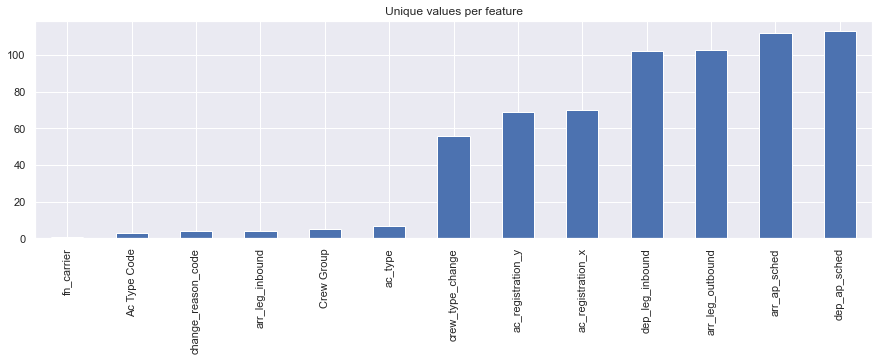

In [29]:
# Get unique values
unique_values = full_df.select_dtypes(include = 'object').nunique().sort_values().drop(['TLC_trans', 'fn_number'])

# Plot
unique_values.plot.bar(figsize = (15,4), title = "Unique values per feature")